In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Ejercicio 1: Probabilidad e Inferencia Bayesiana

Se cuenta con un detector que puede medir tres tipos de particulas: electrones, muones y tauones. El aparato solo informa de la detección de una partícula, pero no sobre el tipo de partícula de la cual se trata. Además, para cada tipo de partícula, el detector tiene una eficiencia diferente. Es decir, que el aparato no detecta _todas_ las partículas que le llegan, sino solo una fracción de ellas y esa fracción depende del tipo de partícula.

Ante la llegada de una partícula al detector, la eficiencia puede verse como una probabilidad de exito de medicion $p_i$ para cada tipo de particula, con $i = \{\text{electrón, muón, tauón}\}$.

**a.** ¿Cuál son los posibles resultados de una medición única con el detector? ¿Puede relacionar estos resultados con el espacio de muestreo de un experimento? Describa cómo sería el experimento en cuestión.

**Respuesta**. 

El detector no distingue entre las partículas que le llegan, de manera que solo tiene dos posibles resultados: detección o no detección. Esto corresponde al espacio de muestreo de un experimento realizado con el detector que consista en la llegada de una única partícula al aparato.

***

Se desea realizar la carecterización del detector. Es decir, obtener información sobre su funcionamineto. En otras palabras, se busca determinar la eficiencia para cada clase de partículas. 

Para esto se realizó una serie de mediciones pero no se procesaron los datos. El experimento consistió en hacer llegar una serie de partículas de tipo conocido al detector y contar en cuantas ocasiones el aparato registraba una medición. Suponga que la interacción con cada partícula es independiente de las demás.

Los datos se encuentran en el archivo `datos_ej1.csv`, que puede leerse con `pandas`. Las columnas indican el tipo de partícula y si fue detectada o no por el instrumento. 

**b.** Lea los datos con la celda de abajo y describa un poco de qué se tratan (número de mediciones de cada tipo, etc.)

In [2]:
!wget https://raw.githubusercontent.com/exord/UNSAM_IA/master/datasets/datos_ej1.csv

In [3]:
import pandas as pd
df = pd.read_csv('datos_ej1.csv', header=0)
df.head()

print('Número de partículas de cada tipo')
print(df['Tipo'].value_counts())
print('----')
print('Total: ', len(df))
print('****')
print('Número de detecciones por tipo')
print(df.loc[df['Detec']==1, 'Tipo'].value_counts())
print('----')
print('Total: ', len(df.loc[df['Detec']==1]))

Número de partículas de cada tipo
electron    173
tau         165
muon        162
Name: Tipo, dtype: int64
----
Total:  500
****
Número de detecciones por tipo
electron    123
muon        119
tau          85
Name: Tipo, dtype: int64
----
Total:  327


***
**c.** ¿Cuál es la función de verosimilitud que mejor describe el problema para cada tipo de partícula? **Justifique**

**Respuesta**. 

Ante la llegada de una partícula de tipo *i*, el detector presenta dos opciones: medir o no medir, con una probabilidad que llamaremos $\mu_i$. Este parámetro correponde a la eficiencia del detector para ese tipo de partícula. 

Si consideramos que la respuesta del detector a una partícula es independiente de la llegada de otras partículas, entonces la distribución que puede usarse para describir el resultado del impacto de una partícula de tipo $i$ es una distribución de Bernoulli. Si consideramos que el resultado de un experimento puede describirse como una variable aleatoria binaria $t_i$, tal que $t_i \in \{0, 1\}$, entonces, podemos escribir

$$
p(t_i) = \mathcal{Ber}(t_i | \mu_i) = \mu_i^{t_i} (1 - \mu_i)^{1 - t_i}\;\;.
$$

Si ahora se lanza una serie de partículas de un dado tipo, y nos interesa el conteo de la cantidad de partículas medidas por el detector, se sigue que la distribución adecuada es la binomial. Si llamamos $k_i$ al número de partículas detectadas de la clase $i$, tenemos

$$
p(k_i) = \mathcal{Bin}(k_i | \mu_i, N_i) = {N_i\choose k_i}\mu_i^{k_i} (1 - \mu_i)^{N_i - k_i}\;\;,
$$
donde $N_i$ es la cantidad de partículas de tipo $i$ que llegaron al detector.


***

**d.** Calcule el estimador de máxima verosimilitud para la eficiencia de cada tipo de partículas.

**Respuesta**. 

Usando los datos provistos para realizar la caracterización, podemos calcular estimadore de la eficiencia para cada tipo de partícula. El estimador de máxima verosimilitud del parámetro $\mu$ de una binomial es simplemente:

$$
\mu_\text{ML} = \frac{k}{N}\;\;,
$$
donde las $k$ y $N$ son, como arriba, el número de detecciones y el número de experimentos. 

Puede calcularse un estimador de máxima verosimilitud para cada tipo de partícula.

In [4]:
print('Estimadores de máxima verosimilitud')

# Itero para cada clase de partícula
# Hago un diccionario porque vamos a usar el estimador más tarde
muML = {}

for c in df['Tipo'].unique():
    k = np.sum((df['Tipo']==c) & (df['Detec']==1))
    N = np.sum(df['Tipo']==c)
    print('mu_{} = {:.3f}'.format(c, k/N))
    
    muML[c] = k/N

Estimadores de máxima verosimilitud
mu_muon = 0.735
mu_tau = 0.515
mu_electron = 0.711


***

**e.** Suponiendo que antes de la medición no se cuenta con ninguna información acerca de la eficiencia del detector, determine la distribución posterior de cada $p_i$ tras la medición. 

*Ayuda*: tome a cada partícula como un problema independiente.

¿De qué manera le conviene tomar la distribución prior para simplificar el problema?

**Respuesta**. 

Como no se cuenta con información sobre la eficiencia, con excepción del hecho de que debe ser un número comprendido entre 0 y 1, podemos usar un prior uniforme sobre los parámetros $\mu$ de cada clase de partícula.

Como vimos varias veces, es conveniente en este caso parametrizar la distribución uniforme como una distribución Beta, $p(\mu_i) = \mathcal{Beta}(\mu_i | \alpha=1, \beta=1)$, porque constituye el prior conjugado de una verosimilitud de tipo Binomial. Entonces, la distribución posterior será también una distribución Beta, cuyos hiperparámetros se modificarán de la siguiente manera:

$$
\begin{array}{l}
\alpha \rightarrow \alpha + k_i\\
\beta \rightarrow \beta + (N_i - k_i)\;\;.
\end{array}
$$

Es decir, se le suma el número de éxitos (detecciones) a $\alpha$ y el número de no-detecciones a $\beta$.
La distribución posterior del parámetro $\mu_i$ es entonces

$$
p(\mu_i | N_i, k_i, \alpha, \beta) = \mathcal{Beta}(\mu_i | \alpha=1 + k_i, \beta=1 + (N - k_i))\;\;.
$$

Pero también se puede calcular numéricamente, como se hace en el ejemplo de abajo.

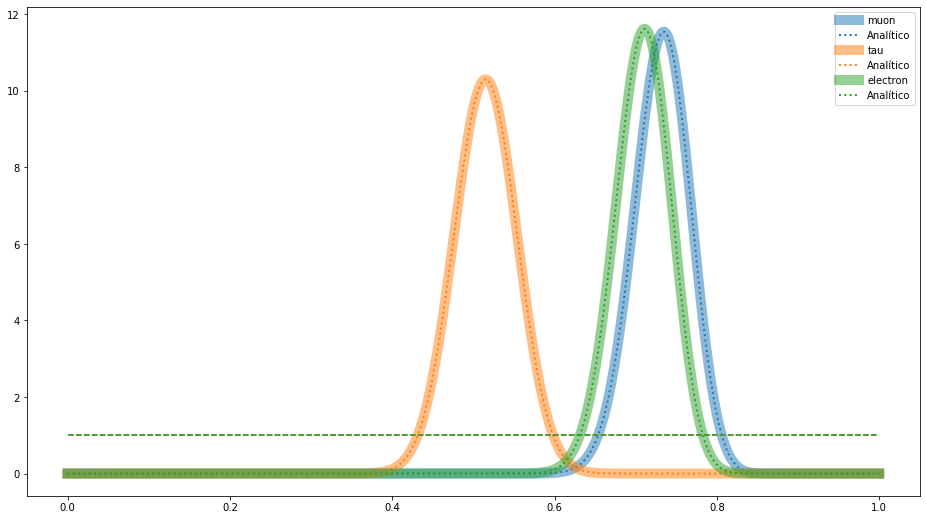

In [5]:
import scipy.stats as st

prior_dist = st.beta(1, 1)
eta, step = np.linspace(0, 1, 500, retstep=True)

fig = plt.figure(figsize=(16, 9))
for i, c in enumerate(df.Tipo.unique()):
    
    # Get data for that class and count number of successes.
    n = len(df.loc[df.Tipo==c, 'Detec'])
    x = np.sum(df.loc[df.Tipo==c, 'Detec'])
    
    # Compute likelihood * prior and normalise to get posterior.
    prior = prior_dist.pdf(eta)
    likelihood = st.binom(n, eta).pmf(x)
    evidence = np.sum(step * prior * likelihood)
    
    plt.plot(eta, prior * likelihood / evidence, label=c, color='C{}'.format(i), lw=10, alpha=0.5)
    
    # Plot analytical solution using conjugate prior
    plt.plot(eta, st.beta.pdf(eta, 1 + x, 1 + (n - x)), color='C{}'.format(i) ,ls=':', lw=2, label='Analítico')
    
    # Plot prior for comparison.
    plt.plot(eta, prior, color='C{}'.format(i), ls='--')

plt.legend(loc=0)

***

**f.** ¿Cómo cambia la respuesta anterior si en lugar de no contar con información previa al experimento, el constructor proveyera la siguiente información:

"El detector cuenta con una eficiencia de 75%, determinada con un error del 5%, idéntica para cada clase".

No hace falta que haga las cuentas, solo indique cómo cambia la resolución del punto **d**.

**Respuesta**. 

Ahora tenemos información sobre la eficiencia del detector. Podemos parametrizar este conocimiento a través de la función prior. En este caso, se impone el uso de una distribución normal con centro en 0.75 y varianza $(0.05)^2$:

$$
p(\mu_i) = \mathcal{N}(\mu=0.75, \sigma=0.05)\;\;\;\text{para }i\in\{\text{electrón, muón, tauón\}}\;\;.
$$

En este caso, al no ser el prior el conjugado de la verosimilitud binomial, tenemos que hacer el cálculo del producto y normalizar (numéricamente). Esto puede hacerse con una pequeña variación a la celda de arriba.

La comparación con el gráfico resultante muestra el efecto que tiene el prior en la inferencia que se podría hacer sobre las eficiencias del detector (teniendo en cuenta que se trata del mismo conjunto de datos en ambos casos).

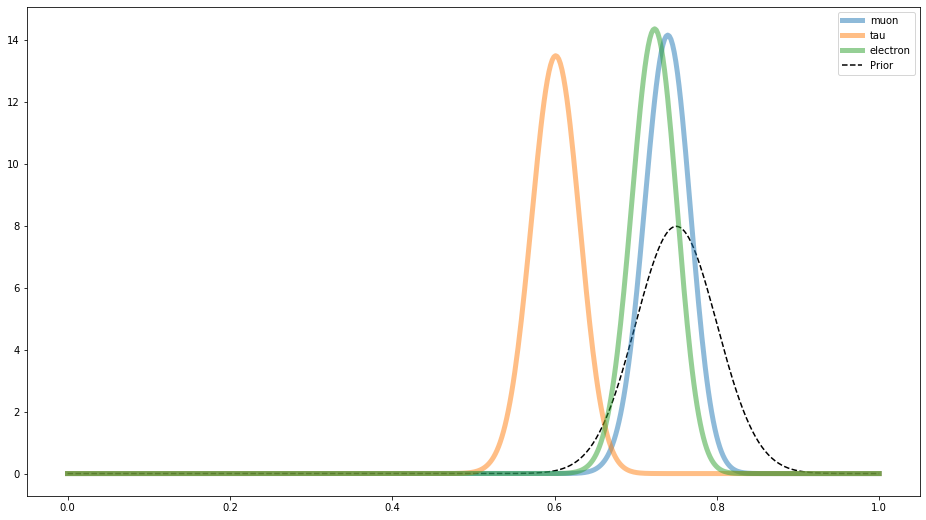

In [6]:
import scipy.stats as st

prior_dist = st.norm(0.75, 0.05)
eta, step = np.linspace(0, 1, 500, retstep=True)

fig = plt.figure(figsize=(16, 9))
for i, c in enumerate(df.Tipo.unique()):
    
    # Get data for that class and count number of successes.
    n = len(df.loc[df.Tipo==c, 'Detec'])
    x = np.sum(df.loc[df.Tipo==c, 'Detec'])
    
    # Compute likelihood * prior and normalise to get posterior.
    prior = prior_dist.pdf(eta)
    likelihood = st.binom(n, eta).pmf(x)
    evidence = np.sum(step * prior * likelihood)
    
    plt.plot(eta, prior * likelihood / evidence, label=c, color='C{}'.format(i), lw=5, alpha=0.5)
        
# Plot prior for comparison.
plt.plot(eta, prior, color='k'.format(i), ls='--', label='Prior', zorder=0)

plt.legend(loc=0)

***

**g.** Luego de caracterizado, el detector mide la llegada de una particula. ¿Qué puede decir de la probabilidad de cada uno de los tipos de partículas?

*Ayuda*: Para resolver el problema necesitará la eficiencia de detección para cada tipo de partícula. Puede utilizar el estimador de máxima verosimilitud que calculó en el inciso **d.**

**Respuesta**.

Ahora que el detector se encuentra caracterizado, podemos hacer inferencias sobre el tipo de partícula ante la obtención de una nueva detección, $t^\prime = 1$.

Si llamamos $c_i$ a la proposición que afirma que la partícula detectada es de la clase $i$, queremos encontrar, $p(c_i | t^\prime, \mu_i)$, es decir, considerando la distribución de $\mu_i$ obtenida arriba.

Para hacer el cálculo, usamos el teorema de Bayes para expresar la probabilidad que buscamos en términos de cosas que conocemos.

$$
p(c_i | t^\prime = 1, \mu_i) = p(t^\prime = 1| c_i, \mu_i) \cdot p(c_i) / p(t^\prime = 1)\;\;.
$$

Ahora la tarea es calcular cada uno de los términos de la derecha. La probabilidad de una detección nueva, dado un tipo de partícula y todos los datos anteriores es lo que se conoce como la distribución predictiva posterior. La vamos a calcular entera más abajo, pero en este punto, se pide que usemos simplemente el resultado de máxima verosimilitud conseguido arriba. De esta manera, para $i\in\{\text{electrón, muón, tauón\}}$, tenemos:

$$
p(t^\prime = 1| c_i, \mu_i) = \mu_{i;\text{ML}} = \frac{k_i}{N_i}\;\;.
$$

Además, no se provee información sobre el tipo de partícula que llega al detector, por lo que podemos tomar un prior uniforme.

$$
p(c_i) = \frac{1}{3} \;\;.
$$

Por último, el término normalizador se obtiene, como de costumbre, marginalizando sobre la clase:

$$
p(t^\prime = 1) = \sum_i p(t^\prime = 1| c_i, \mu_i) \cdot p(c_i) = \frac{1}{3} \sum_i \mu_{i; \text{ML}}\;\;,
$$
que es igual al promedio de las eficiencias.

Como tenemos el mismo prior para todas las clases, sale de factor común y se cancela con el del numerador, por lo que el resultado final es

$$
p(c_i | t^\prime = 1, \mu_i) = \frac{\mu_{i; \text{ML}}}{\sum_j{\mu_{j;\text{ML}}}}
$$


Obtengamos los números:

In [7]:
# Calculamos la suma de las eficiencias
summu = np.sum(list(muML.values()))

for i, c in enumerate(df.Tipo.unique()):
    
    proba = muML[c] / summu
    print('P({} | nueva detección) = {:.3f}'.format(c, proba))

P(muon | nueva detección) = 0.375
P(tau | nueva detección) = 0.263
P(electron | nueva detección) = 0.363


***

**h.** Llega al detector una partícula originada en una lluvia de la siguiente composición: 50% electrones, 10% muones, 25% tauones, 15% taquiones (para los cuales el detector es completamente insensible). ¿Cuál es la probabilidad de que el aparato indique una detección?

*Ayuda*: Al igual que en el inciso anterior, para resolver el problema necesitará la eficiencia de detección para cada tipo de partícula. Puede utilizar el estimador de máxima verosimilitud que calculó en el inciso **d.**

**Respuesta**. 

En este punto, se pide calcular la probabilidad de que el detector mida la llegada de una partícula cuando se lo irradia con una lluvia de composición conocida. Es decir, necesitamos calcular $p(t^\prime | I)$, donde la información que se da, $I$, corresponde a la composición de la lluvia. 

Como el conjunto de proposiciones $\{c_i : i = \text{electrón, muón, tauón, taquión}\}$ cubre todo el espacio de muestreo (es decir, que la partícula tiene que ser alguna de las del grupo, porque el las probabilidades prior suman 1),  y se trata de proposiciones disjuntas, (ya que si una partícula pertenece a una clase, tiene probabilidad cero de pertencer a otra), estamos ante un caso típico en el que conviene usar la ley de probabilidad total para calcular la probabilidad buscada en función de términos que conocemos. 

Usando la regla de la suma, se puede escribir:

$$
p(t^\prime = 1 | I) = \sum_i {p(t^\prime = 1 | c_i, I)p(c_i | I)}\;\;.
$$

Fíjense que en todos lados, podríamos haber sacado la $I$, pero hacerla aparecer nos recuerda que estamos trabajando con la información previa que obtuvimos en los demás puntos y en el enunciado (eficiencias y composición de la lluvia).

Si, como nos sugieren, aproximamos $p(t^\prime = 1 | c_i, I)$ por su estimador de máxima verosimilitud, tenemos:

$$
p(t^\prime = 1 | I) = \sum_i {\mu_{i;\text{ML}}\;p(c_i | I)}\;\;.
$$

Hagamos el cálculo.

In [8]:
# Definimos un diccionario con los priors, que corresponden a la composición de la lluvia
prior = {'electron': 0.5,
        'tau': 0.25,
        'muon': 0.10,
        'taquion': 0.15}

# Ahora agregamos al diccionario de las eficiencias, el valor del taquión.
muML['taquion'] = 0.0

# Lista con el producto de todos las clases
a = [muML[i] * prior[i] for i in muML.keys()]

print('Probabilidad de detectar una partícula, p(t\') = {:.3f}'.format(np.sum(a)))

Probabilidad de detectar una partícula, p(t') = 0.558


***

**i (OPTATIVO).** Vuelva a realizar el cálculo de los puntos **g** y **h** considerando la distribución posterior completa. Compare sus conclusiones con los puntos anteriores.

*Ayuda*: Para esto, necesitará realizar una marginalización sobre el parámetro de eficiencia, para obtener la probabilidad posterior de obtener una detección, dada una clase de partícula $i$.

**Respuesta**. 

En el punto **g**. se pide la probabilidad de cada clase ante el evento de la llegada de una partícula ($t^\prime=1$).

Habíamos visto, más arriba, que:
$$
p(c_i | X, t^\prime=1) = \frac{p(t^\prime=1 | c_i, X)\,p(c_i | X)}{\sum_j{p(t^\prime=1 | c_j, X)\,p(c_j | X)}}\;\;,
$$
donde ahora indicamos de forma explícita la dependencia con $X$, que son los datos anteriores. 

Los términos "prior", $p(c_i | X)$, se reducen a $p(c_i)$, porque los datos anteriores no dicen nada sobre la naturaleza de esta nueva partícula. En este punto se podría pensar en obtener algo con los datos viejos, que tampoco estaría mal. Al igual que arriba, pueden salir de factor común y cancelarse.

El tema es calcular $p(t^\prime=1 | c_i, X)$ de forma completa, en lugar de tomar el estimador de máxima verosimilitud. Esto es un elemento de la distribución predictiva posterior, porque querés saber que chances hay de detectar algo dados los datos anteriores.  Es la forma más completa de expresar una predicción de probabilidad. Se puede escribir a partir de la distribución conjunta, $p(t^\prime=1, \mu_i | c_i, X)$, donde $\mu_i$ es la eficiencia para la clase $i$ calculada más arriba:

$$
p(t^\prime=1 | c_i, X) = \int {p(t^\prime=1, \mu_i | c_i, X)\,\mathrm{d}\mu_i} = \int{p(t^\prime=1 | c_i, X, \mu_i)\,p(\mu_i | c_i, X)\,\mathrm{d}\mu_i}
$$

El primer elemento del término de la derecha,  $p(t^\prime=1 | c_i, X, \mu_i)$ es la verosimilitud de un evento de detección. Obviamente, no importa el condicional sobre $X$, porque las medidas son independientes; y condicionar sobre $i$ es lo mismo que hacerlo sobre $\mu_i$. Por lo tanto, tenemos la función $p(t^\prime=1 | \mu_i)$, que no es más que la distribución de Bernoulli, como vimos en el punto **c** o sea $p(t^\prime=1 | \mu_i) = \mu_i$.

El segundo término, $p(\mu_i | c_i, X)$ es la posterior calculada antes (punto **e.**). De nuevo, no importa el condicionamiento sobre $i$, de manera que queda $p(\mu_i | X)$.

En definitiva, lo que tenemos que hacer es integrar la posterior obtenida en el punto e. multiplicada por $\mu_i$. Es decir, calcular el valor medio de la eficiencia sobre la posterior, o el valor de expectación de la posterior. Como las distribuciones posterior son muy simétricas alrededor del máximo, esto será muy parecido a tomar el valor de máxima verosimiitud, pero en el caso general, o si hubiera habiado menos eventos, por ejemplo, la diferencia sería apreciable.

In [9]:
# Integración numérica de la manera más fácil posible
import scipy.stats as st

# Se muestrea la eficiencia mu
mu, step = np.linspace(0, 1, 500, retstep=True)

post_pred = {}
# Iteramos para cada clase de partícula
for i, c in enumerate(df.Tipo.unique()):

    # Calculamos número de eventos y detecciones para cada tipo de partícula
    Ni = len(df.loc[df.Tipo==c, 'Detec'])
    ki = np.sum(df.loc[df.Tipo==c, 'Detec'])

    # Sabemos que la posterior es una beta(1 + ki, 1 + Ni - ki)    
    posterior = st.beta.pdf(eta, 1 + ki, 1 + (Ni - ki))

    # Calculemos la posterior predictiva
    post_pred[c] = np.sum(step * mu * posterior)
    
    print('La proabilidad de detectar una partícula de tipo {} es {:.3f}.'.format(c, post_pred[c]))

La proabilidad de detectar una partícula de tipo muon es 0.732.
La proabilidad de detectar una partícula de tipo tau es 0.515.
La proabilidad de detectar una partícula de tipo electron es 0.709.


In [10]:
# Comparamos con los valores de máxima verosimilitud
print(' '*10+'Post\tML')
for i, c in enumerate(df.Tipo.unique()):
      print('{:10s}{:.3f}\t{:.3f}'.format(c, post_pred[c], muML[c]))

          Post	ML
muon      0.732	0.735
tau       0.515	0.515
electron  0.709	0.711


Podemos ver que la diferencia es casi despreciable. El resto del punto se resuelve remplazando como en el punto **g**, porque los valores de prior son los mismos, y podemos entonces simplificar como en ese punto.

Veamos:

In [11]:
# Calculamos la suma de las eficiencias
summu = np.sum(list(post_pred.values()))

for i, c in enumerate(df.Tipo.unique()):
    
    proba = post_pred[c] / summu
    print('P({} | nueva detección) = {:.3f}'.format(c, proba))

P(muon | nueva detección) = 0.374
P(tau | nueva detección) = 0.263
P(electron | nueva detección) = 0.362


***

En el punto **h**. se pide calcular la proba de detección frente a la llegada de una partícula emanada de un haz con una composición conocida. O sea, hay que calcular $p(t^\prime = 1 | X)$. Al igual que antes, esto no es más que la suma que aparece en el denominador de la primera ecuación que puse arriba, $\sum{p(t^\prime = 1 | c_j, X)\,p(c_j | X)}$, pero ahora los priors de cada partícula se calculan a partir del enunciado, y la sumatoria debe hacerse también sobre los taquiones.

La única diferencia es que, de nuevo, hay que tomar el valor de la posterior predictiva en lugar de la de máxima verosimilitud.

In [12]:
# (Volemos a) definir un diccionario con los priors, que corresponden a la composición de la lluvia 
# Esto no hace falta, pero es para poner todo junto en la misma celda
prior = {'electron': 0.5,
        'tau': 0.25,
        'muon': 0.10,
        'taquion': 0.15}

# Ahora agregamos al diccionario de las posteriores predictivas el valor del taquión.
post_pred['taquion'] = 0.0

# Lista con el producto de todos las clases
a = [post_pred[i] * prior[i] for i in post_pred.keys()]

print('Probabilidad de detectar una partícula, p(t\') = {:.3f}'.format(np.sum(a)))

Probabilidad de detectar una partícula, p(t') = 0.556


****

### Ejercicio 2: Modelos Lineales para Regresión

En su laboratorio han adquirido, con costo millonario, un nuevo *criptómetro*. Los turnos para utilizarlo enseguida comienzan a acabarse, ya que todos quieren hacerse manos de él por unos momentos. En este escenario, en una serie de mediciones realizadas con el *criptómetro* se encuentra una correlación entre la propiedad $X$ de un material y su cripticidad $y$. 

Una búsqueda rápida en la literatura especializada muestra que hay muy poco documentado sobre tal correlación. Todo parece indicar que llevaría años de trabajo e inversión desarrollar un modelo realista que la explique. 
Pero como $X$ es muy fácil de medir, Ud. piensa que podría explotar esta relación para construir un *criptómetro* económico. Este permitiría estimar la *cripticidad* $y$ de un material de una manera sencilla y eficaz, con un costo reducido. Se dispone entonces a encontrar un modelo que pueda predecir $y$ a partir de $X$ con el menor error posible, a fin de desarrollar el *criptómetro* de bajo costo.

Las mediciones que ha encontrado para la cripticidad $y$ en función de $X$ son las siguientes

In [13]:
X = np.array([0.00000000e+00, 4.15893378e-03, 1.66357351e-02, 3.74304040e-02,
       6.65429404e-02, 1.03973344e-01, 1.49721616e-01, 2.03787755e-01,
       2.66171762e-01, 3.36873636e-01, 4.15893378e-01, 5.03230987e-01,
       5.98886464e-01, 7.02859808e-01, 8.15151020e-01, 9.35760100e-01,
       1.06468705e+00, 1.20193186e+00, 1.34749454e+00, 1.50137509e+00,
       1.66357351e+00, 1.83408980e+00, 2.01292395e+00, 2.20007597e+00,
       2.39554586e+00, 2.59933361e+00, 2.81143923e+00, 3.03186272e+00,
       3.26060408e+00, 3.49766331e+00, 3.74304040e+00, 3.99673536e+00,
       4.25874819e+00, 4.52907888e+00, 4.80772745e+00, 5.09469388e+00,
       5.38997818e+00, 5.69358034e+00, 6.00550037e+00, 6.32573828e+00,
       6.65429404e+00, 6.99116768e+00, 7.33635918e+00, 7.68986855e+00,
       8.05169579e+00, 8.42184090e+00, 8.80030387e+00, 9.18708471e+00,
       9.58218342e+00, 9.98560000e+00]).reshape(-1,1)
y = np.array([ 2.34658081,  0.12232961,  3.28408066,  6.50202338,  1.11491047,
        1.65815688,  7.46238396,  5.5879876 ,  2.81212403,  6.00471259,
        4.07938942,  4.67934907,  6.86236068,  2.68607344,  3.74378497,
        6.74267086,  6.4138967 ,  9.54710971,  7.83545878,  7.58260975,
       13.31941341, 11.02803986, 12.15464143, 10.30918401, 12.19094142,
       13.50273522, 11.73650991, 13.979756  , 12.43200611, 12.65491575,
       11.96171543, 14.94378399, 12.13494977, 10.47716903, 12.54112238,
        9.69890304, 11.14506196,  8.28167544,  8.76715857, 10.24728082,
       10.57023985,  9.65935661,  9.0763293 ,  8.61455788,  7.12765358,
        7.66762068,  7.67915514,  8.93185613,  7.95844691,  5.66816807])

**a.** Grafique los datos obtenidos.

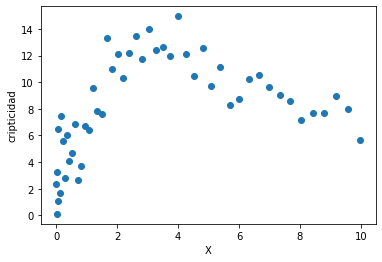

In [14]:
plt.scatter(X,y)
plt.xlabel('X')
plt.ylabel('cripticidad')
plt.show()

**b.** Separe 20% de los datos para usar como conjunto de testeo. Los datos están repartidos de forma aleatoria.
A partir de este punto, trabaje solamente con el conjunto de entrenamiento.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**c.** Para tener un baseline con qué comparar, decide ajustar una parábola a los datos.

* *i.* Encuentre los parámetros de este modelo.

* *ii.* Grafique sobre los datos de entrenamiento la predicción del modelo, y calcule el RMSE sobre ellos.

* *iii.* Estime el error que espera obtener sobre datos que no ha visto anteriormente. Recuerde: No utilice los datos de testeo.


i) Los parametros del modelo son: w = [ 3.85854084  3.38169539 -0.3427004 ]

ii) RMSE_train = 2.1


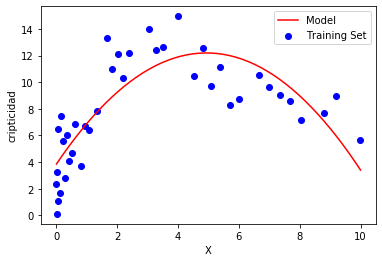


iii) Para obtener una estimación del desempeño del modelo sobre datos nuevos, utilizo cross validation
     RMSE_CV = 2.3 +- 0.3


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

parabola = Pipeline([
    ('pp', PolynomialFeatures(degree=2)),
    ('reg', LinearRegression(fit_intercept=False))
])

parabola.fit(X_train, y_train)

print("\ni) Los parametros del modelo son: w = {}".format(parabola.named_steps['reg'].coef_))

from sklearn.metrics import mean_squared_error
print("\nii) RMSE_train = {:.1f}".format(np.sqrt(mean_squared_error(y_train, parabola.predict(X_train)))))
plt.scatter(X_train, y_train, label='Training Set', c = 'b')
x_ = np.linspace(0,10).reshape(-1,1)
plt.plot(x_, parabola.predict(x_), label='Model', c = 'r')
plt.legend()
plt.xlabel('X')
plt.ylabel('cripticidad')
plt.show()

from sklearn.model_selection import cross_val_score
print("\niii) Para obtener una estimación del desempeño del modelo sobre datos nuevos, utilizo cross validation")

val = cross_val_score(parabola, X_train, y_train, scoring='neg_root_mean_squared_error')
print("     RMSE_CV = {:.1f} +- {:.1f}".format(-val.mean(), val.std()))


**d.** Decidido a encontrar un mejor ajuste, desea probar con polinomios de grado mayor. Encuentre el grado polinomial óptimo, y calcule el error (RMSE) que espera obtener sobre datos no vistos anteriormente. Justifique su elección, por ejemplo con un gráfico. (Recuerde: No utilice el conjunto de testeo)


El grado que mejor RMSE_CV obtiene es 5 con un RMSE_CV = 1.73 +- 0.45.
(Tomo como referencia el grado de menor RMSE_CV promedio, sin tener en cuenta su desviacion estandar)


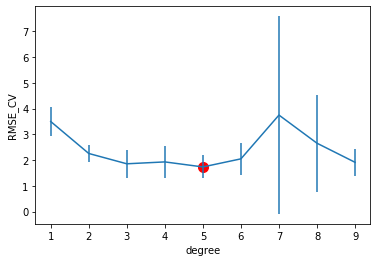

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

rmse_mean = []
rmse_std = []
for d in range(1,20):
    polinomios = Pipeline([
        ('pp', PolynomialFeatures(degree=d)),
        ('reg', LinearRegression(fit_intercept=False))
    ])
    val = cross_val_score(polinomios, X_train, y_train, scoring='neg_root_mean_squared_error')
    rmse_mean.append(-val.mean())
    rmse_std.append(val.std())

best = np.argmin(rmse_mean)
print("\nEl grado que mejor RMSE_CV obtiene es {} con un RMSE_CV = {:.2f} +- {:.2f}.".format(best+1, 
                                                                                         rmse_mean[best], 
                                                                                         rmse_std[best]))
print("(Tomo como referencia el grado de menor RMSE_CV promedio, sin tener en cuenta su desviacion estandar)")
plt.errorbar(range(1,10),rmse_mean[:9], rmse_std[:9])
plt.scatter(best+1,rmse_mean[best], c = 'r', s=1e2)
plt.xlabel('degree')
plt.ylabel('RMSE_CV')
plt.show()

**f.** Ya está bastante satisfecho con su modelo, pero antes de tomar una descisión, decide probar modelos de regresión polinomial regularizados. Encuentre simultáneamente el grado óptimo polinomial $M$ y el parámetro de regularización $\alpha$ para un modelo Ridge. Calcule el error (RMSE) que espera obtener sobre datos que no ha visto anteriormente. (Recuerde: No utilice el conjunto de testeo). Puede probar con valores de $M\in[1,20]$ y $\alpha\in[10^{-2}, 1]$.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

model = Pipeline([
    ('pp', PolynomialFeatures()),
    ('reg', Ridge())
])

search_params = {
    'pp__degree': range(1,7), #Cambie a 7 para elminar warnings. Poner 20 no cambia el resultado.
    'reg__alpha': np.logspace(-2,0,10)
}

search = GridSearchCV(model, search_params, scoring='neg_root_mean_squared_error')
search.fit(X_train,y_train)

best_degree, best_alpha = search.best_params_['pp__degree'], search.best_params_['reg__alpha']

print("\nLos valores óptimos para los hiperparámetros son:\n\tGrado = {}\n\talpha = {:}".format(best_degree,
                                                                                                   best_alpha))
print("Que dan un RMSE_CV = {:.2f} +- {:.2f}".format(-search.best_score_,
                                                    search.cv_results_['std_test_score'][search.best_index_]))



Los valores óptimos para los hiperparámetros son:
	Grado = 5
	alpha = 0.5994842503189409
Que dan un RMSE_CV = 1.68 +- 0.45


**g.** Ya habiendo desarrollado un buen modelo predictivo, decide reportarlo junto a una estimación objetiva y sin bias del error que espera obtener. Para esto, de todos los modelos probados anteriormente elija el óptimo. y entrénelo sobre el todo el conjunto de Train. Luego calcule la performance (RMSE) sobre el conjunto de test.


RMSE_test = 1.47


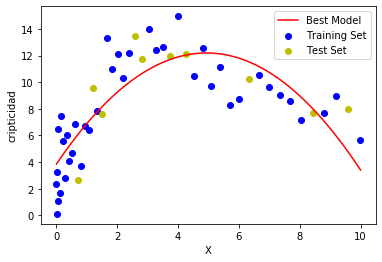

In [19]:
best_model = search.best_estimator_

best_model.fit(X_train, y_train)
rmse_test = np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))

print("\nRMSE_test = {:.2f}".format(rmse_test))

plt.scatter(X_train, y_train, label='Training Set', c = 'b')
plt.scatter(X_test, y_test, label='Test Set', c = 'y')
x_ = np.linspace(0,10).reshape(-1,1)
plt.plot(x_, parabola.predict(x_), label='Best Model', c = 'r')
plt.legend()
plt.xlabel('X')
plt.ylabel('cripticidad')
plt.show()

**g.** Para una aplicación específica, le piden que calcule la *cripticidad* $y$ para una medición de $X=4.7$. Calcula la predicción de su modelo. ¿Qué error espera que tenga esta predicción? ¿Porqué?

A continuación, le piden que calcule la *cripticidad* de una muestra con $X=20$. ¿Cómo cambian las respuestas anteriores?



In [20]:
X=[[4.7]]
pred = best_model.predict(X)

print("\nDado que el punto X = {} pertenece a la misma región que mi conjunto de Test, ".format(X[0][0])
     +"es de esperar que el errror sea comparable al obtenido en RMSE_test.")
print("y(X={}) = {:.2f} +- {:.2f}".format(X[0][0], pred[0], rmse_test))


X=[[20.]]
pred = best_model.predict(X)
print("\nDado que el punto X={} se encuentra alejado de los puntos de mi dataset, "
     +"no puedo construir un conjunto de Test adecuado para estimar su error. "
     +"Por lo tanto, desconozco como se comportará el modelo allí.")
print("y(X={}) = {:.2f} +- ??".format(X[0][0], pred[0]))


Dado que el punto X = 4.7 pertenece a la misma región que mi conjunto de Test, es de esperar que el errror sea comparable al obtenido en RMSE_test.
y(X=4.7) = 11.87 +- 1.47

Dado que el punto X={} se encuentra alejado de los puntos de mi dataset, no puedo construir un conjunto de Test adecuado para estimar su error. Por lo tanto, desconozco como se comportará el modelo allí.
y(X=20.0) = -3425.14 +- ??


**h (OPTATIVO).** El desarrollo del criptómetro parece prometedor. Sin embargo, usted recuerda de sus clases de inferencia Bayesiana que para tener un completo control sobre los parámetros de un modelo uno debería conocer el posterior del mismo. Un fin de semana lluvioso, decide calcular la distribución posterior de los parámetros de su mejor modelo.

* Calcule el posterior de los parametros $w$ de su modelo, asumiendo que las variables $y$ están normalmente distribuídas con una precisión $\beta = 1$. Plotee el posterior como función de cada $w$ (o al menos, alguno), marginalizando en el resto. **Ayuda**: Dada una multinormal $\mathcal{N} (\vec{w} | \vec{m}, S)$, marginalizar en todas las variables menos $w_i$ da como resultado una normal con media $m_i$ y varianza $S_{i,i}$: $\mathcal{N}(w_i |\mu = m_i, \sigma^2 = S_{i,i})$.

* Calcule la distribución predictiva posterior de la *cripticidad*, teniendo en cuenta los datos del conjunto de entrenamiento. Grafíquela junto con los datos de entrenamiento. Comente sobre el comportamiento de la misma.

**i)**
Para construir los posteriors, recordamos las formulas vistas en clase:
$$
\vec{m}_N = \beta {\bf S}_N \Phi^T \vec{t}\\
{\bf S}_N^{-1} = \alpha {\bf 1} + \beta \Phi^T \Phi
$$

El posterior será una multinormal con medias $\vec m_N$ y matriz de covarianza ${\bf S}_N$, es decir $$\vec \omega \sim \mathcal{N} (\vec m_N, {\bf S}_N)$$. Al marginalizar una multinormal en todas menos una de las variables, el resultado es una normal: $$\omega_i \sim \mathcal{N} ((\vec m_N)_i, ({\bf S}_N)_{ii})$$


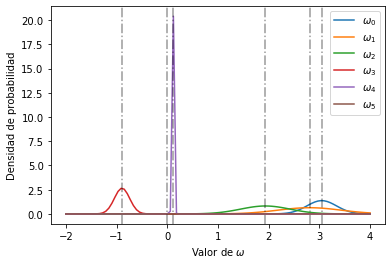

In [21]:
#Construyo la matriz de diseño
beta = 1.0
alpha = 2*best_alpha #esta es una tecnicalidad en la definición.
funciones_base = PolynomialFeatures(degree=best_degree)
Phi = funciones_base.fit_transform(X_train)
identity = np.identity(best_degree+1)

SN_inv = alpha*identity + beta * Phi.T.dot(Phi)
#calculo la matriz de covarianza
SN = np.linalg.solve(SN_inv, identity)
#y las medias
m = SN.dot(Phi.T.dot(y_train))

#El posterior de los pesos w es una multinormal de media m y matriz de covarianza SN.: w ~ N(m, SN)
#Si marginalizamos en todos los pesos menos w_i, se obtiene una normal de media m_i y desv. estandar sqrt(SN_ii)
from scipy.stats import norm
post_marg = []

x_ = np.linspace(-2,4,100)

for i in range(m.shape[0]):
    post_marg = norm(loc=m[i], scale=np.sqrt(SN[i,i])).pdf(x_)
    plt.plot(x_, post_marg, label='$\omega_{}$'.format(str(i)))
    plt.axvline(m[i], linestyle='-.', c='black', alpha=0.4)
plt.legend()
plt.xlabel('Valor de $\omega$')
plt.ylabel('Densidad de probabilidad')
plt.show()

**ii)** 
El posterior predictive es la distribución de probabilidad de una predicción $y$ en un nuevo punto $X_{new}$ dado tu modelo fiteado. Este está dado también por una normal: $$y\sim \mathcal{N}\left(\mu = \vec{m}_N\cdot  \phi(X_{new}), \sigma^2 = \beta^{-1} + \phi(X_{new})^T \cdot {\bf S}_N \cdot \phi(X_{new})\right),$$ donde $\phi$ es el vector de las funciones de base usadas.

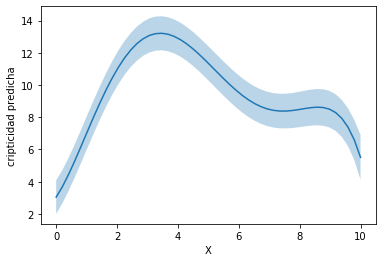

In [22]:
x_ = np.linspace(0,10)
mu = []
sigma = []
posterior_predictive = []
for X_new in x_:
    phi = funciones_base.transform([[X_new]]).reshape(-1,1)
    mu.append(m.dot(phi))
    sigma.append(np.sqrt(1/beta + phi.T.dot(SN.dot(phi))))
    posterior_predictive = norm(loc=mu[-1], scale=sigma[-1])

mu=np.array(mu).reshape(-1)
sigma=np.array(sigma).reshape(-1)
#Podríamos hacer un plot 2D, 
#pero también quizás sea lindo plotear la predicción y una banda de 1 sigma de error
plt.plot(x_, mu)
plt.fill_between(x_,mu-sigma, mu+sigma, alpha=0.3)
plt.xlabel('X')
plt.ylabel('cripticidad predicha')
plt.show()